In [1]:
import _init_paths
from functools import partial
import nengo_dl
import nengo
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pickle
import tensorflow as tf

from configs.exp_configs import tf_exp_cfg as exp_cfg, nengo_dl_cfg as ngo_cfg
from utils.nengo_dl_utils import get_nengo_dl_model, percentile_l2_loss_range
from utils.base_utils.data_prep_utils import get_batches_of_cifar_data
from utils.base_utils.exp_utils import collect_sim_data_spikes, plot_ndl_layer_spikes
from utils.nengo_dl_utils import nengo_dl_focal_loss
from utils.consts.dir_consts import EXP_OTPT_DIR
from utils.consts.exp_consts import SEED

# Get the Nengo-DL model, Training Data etc.

In [2]:
print("EXP_CFG: ", exp_cfg)
print("*"*80)
print("NGO_CFG: ", ngo_cfg)

EXP_CFG:  {'rf': 5e-05, 'batch_size': 200, 'epochs': 20, 'lr': 0.001, 'nn_dlyr': 512, 'tf_model': {'name': 'model_1', 'layers': {'layer_1': Layer(num_kernels=32, kernel_dims=(3, 3), stride_dims=(1, 1)), 'layer_2': Layer(num_kernels=64, kernel_dims=(3, 3), stride_dims=(1, 1)), 'layer_3': Layer(num_kernels=64, kernel_dims=(3, 3), stride_dims=(2, 2)), 'layer_4': Layer(num_kernels=96, kernel_dims=(3, 3), stride_dims=(2, 2)), 'layer_5': Layer(num_kernels=128, kernel_dims=(3, 3), stride_dims=(2, 2))}}, 'tf_wts_otpt_dir': '/scratch/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/tf_trained_wts/'}
********************************************************************************
NGO_CFG:  {'tf_wts_inpt_dir': '/scratch/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/tf_trained_wts/weights', 'ndl_res_otpt_dir': '/scratch/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/ndl_relu_results/', 'spk_neuron': SpikingRectifiedLinear(), 'synapse': 0.0

In [3]:
# While training, we can set inference_only=False, thus ignore the warnings for kernel-regul.
ndl_model, ndl_mdl_probes = get_nengo_dl_model((32, 32, 3), exp_cfg, ngo_cfg, mode="train")
ngo_cfg["n_steps"] = 1 # n_steps = 1 for training mode.

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:588: UserWarning: Activation type <function softmax at 0x2b47103ccef0> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [4]:
ndl_model.net.nodes

[<Node "input_1" at 0x2b8753f947d0>,
 <Node "conv2d.0.bias" at 0x2b8753f94a90>,
 <Node "conv2d.0.bias_relay" at 0x2b8753f94ad0>,
 <Node "conv2d_1.0.bias" at 0x2b8753fb7050>,
 <Node "conv2d_1.0.bias_relay" at 0x2b8753fb7090>,
 <Node "conv2d_2.0.bias" at 0x2b8753fb7750>,
 <Node "conv2d_2.0.bias_relay" at 0x2b8753fb7790>,
 <Node "conv2d_3.0.bias" at 0x2b8753fb7d90>,
 <Node "conv2d_3.0.bias_relay" at 0x2b8753fb7dd0>,
 <Node "conv2d_4.0.bias" at 0x2b876ede0450>,
 <Node "conv2d_4.0.bias_relay" at 0x2b876ede0490>,
 <TensorNode "dense_2.0" at 0x2b876ede0dd0>,
 <Node "dense_2.0.bias" at 0x2b876ede0e90>]

# Train the Nengo-DL model with percentile_loss

In [4]:
with tf.keras.backend.learning_phase_scope(1), nengo_dl.Simulator(
    ndl_model.net, minibatch_size=ngo_cfg["train_batch_size"], seed=SEED, progress_bar=False) as sim:
        losses = {
            ndl_mdl_probes[-1]: nengo_dl_focal_loss,
        }
        
        for probe in ndl_mdl_probes[1:-1]:
           losses[probe] = percentile_l2_loss_range
        
        sim.compile(
            loss=losses,
            metrics=["accuracy"],
            optimizer=tf.keras.optimizers.Adam(lr=exp_cfg["lr"])
        )
        for epoch in range(20):
            batches = get_batches_of_cifar_data(
                    ngo_cfg, ndl_model=ndl_model, ndl_mdl_probes=ndl_mdl_probes, is_test=False)
            sim.fit(batches, epochs=1, steps_per_epoch=250) # steps_per_epoch = 50000 / 200
        sim.save_params("./keras_to_snn_params_percentile_regularized_sfr_250_trained")

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/simulator.py:1773: UserWarning: Number of elements (1) in ['str'] does not match number of Probes (8); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  len(objects),


250/250 [==============================] - 152s 608ms/step - loss: 0.0289 - probe_loss: 0.0289 - probe_1_loss: 0.0000e+00 - probe_2_loss: 0.0000e+00 - probe_3_loss: 0.0000e+00 - probe_4_loss: 0.0000e+00 - probe_5_loss: 0.0000e+00 - probe_6_loss: 0.0000e+00 - probe_7_loss: 0.0000e+00 - probe_accuracy: 0.9739


# Create the Simulator and do inference (TF - ReLU neuron)

In [2]:
ngo_cfg["spk_neuron"], ngo_cfg["synapse"], ngo_cfg["sfr"], ngo_cfg["n_steps"] = (
    nengo.SpikingRectifiedLinear(), 0.005, 500, 60)
ndl_model, ndl_mdl_probes = get_nengo_dl_model(
    (32, 32, 3), exp_cfg, ngo_cfg, mode="test", load_weights=False)
batches = get_batches_of_cifar_data(
            ngo_cfg, ndl_model=ndl_model, ndl_mdl_probes=ndl_mdl_probes, is_test=True)

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:588: UserWarning: Activation type <function softmax at 0x2b145846ff80> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [3]:
print("EXP_CFG: ", exp_cfg)
print("*"*80)
print("NGO_CFG: ", ngo_cfg)

EXP_CFG:  {'rf': 5e-05, 'batch_size': 200, 'epochs': 20, 'lr': 0.001, 'nn_dlyr': 10, 'tf_model': {'name': 'model_1', 'layers': {'layer_1': Layer(num_kernels=32, kernel_dims=(3, 3), stride_dims=(1, 1)), 'layer_2': Layer(num_kernels=64, kernel_dims=(3, 3), stride_dims=(1, 1)), 'layer_3': Layer(num_kernels=64, kernel_dims=(3, 3), stride_dims=(2, 2)), 'layer_4': Layer(num_kernels=96, kernel_dims=(3, 3), stride_dims=(2, 2)), 'layer_5': Layer(num_kernels=128, kernel_dims=(3, 3), stride_dims=(2, 2))}}, 'tf_wts_otpt_dir': '/scratch-deleted-2021-mar-20/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/tf_trained_wts/'}
********************************************************************************
NGO_CFG:  {'tf_wts_inpt_dir': '/scratch-deleted-2021-mar-20/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/tf_trained_wts/weights', 'ndl_res_otpt_dir': '/scratch-deleted-2021-mar-20/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/ndl_relu_result

In [4]:
ndl_model_otpt = []
ndl_model_spks = []

with ndl_model.net:
  nengo_dl.configure_settings(stateful=False)

with nengo_dl.Simulator(
  ndl_model.net, minibatch_size=ngo_cfg["test_batch_size"], progress_bar=True, seed=SEED) as sim:
  sim.load_params("./keras_to_snn_params_percentile_regularized_sfr_500_trained")
  nengo_input = ndl_mdl_probes[0]
  nengo_output = ndl_mdl_probes[-1]
  batch_num=1
  for batch in batches:
    sim_data = sim.predict_on_batch({nengo_input: batch[0]})
    for y_true, y_pred in zip(batch[1], sim_data[nengo_output]):
      ndl_model_otpt.append((np.argmax([y_true]), np.argmax(y_pred[-1]), y_pred))
    if batch_num == 1: # Collect only for one batch, else memory consumption is too high.
      mdl_spks = collect_sim_data_spikes(ndl_mdl_probes, sim_data)
      ndl_model_spks.extend(mdl_spks)
    print("Batch: %s Done." % batch_num)
    batch_num += 1

Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Batch: 1 Done.raph: build stage finished in 0:00:00                            
Batch: 2 Done.
Batch: 3 Done.
Batch: 4 Done.
Batch: 5 Done.
Batch: 6 Done.
Batch: 7 Done.
Batch: 8 Done.
Batch: 9 Done.
Batch: 10 Done.
Batch: 11 Done.
Batch: 12 Done.
Batch: 13 Done.
Batch: 14 Done.
Batch: 15 Done.
Batch: 16 Done.
Batch: 17 Done.
Batch: 18 Done.
Batch: 19 Done.
Batch: 20 Done.
Batch: 21 Done.
Batch: 22 Done.
Batch: 23 Done.
Batch: 24 Done.
Batch: 25 Done.
Batch: 26 Done.
Batch: 27 Done.
Batch: 28 Done.
Batch: 29 Done.
Batch: 30 Done.
Batch: 31 Done.
Batch: 32 Done.
Batch: 33 Done.
Batch: 34 Done.
Batch: 35 Done.
Batch: 36 Done.
Batch: 37 Done.
Batch: 38 Done.
Batch: 39 Done.
Batch: 40 Done.
Batch: 41 Done.
Batch: 42 Done.
Batch: 43 Done.
Batch: 44 Done.


In [5]:
acc = 0
for y_true, y_pred, _ in ndl_model_otpt:
  if y_true == y_pred:
    acc += 1

print(acc/10000)

0.6716


In [5]:
acc = 0
for y_true, y_pred, _ in ndl_model_otpt:
  if y_true == y_pred:
    acc += 1

print(acc/10000)

0.6697


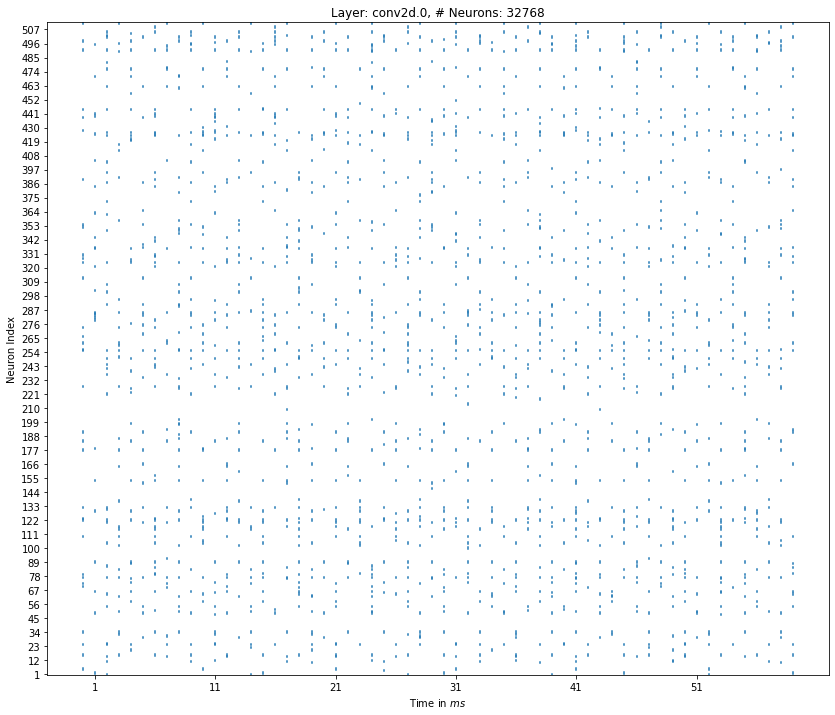

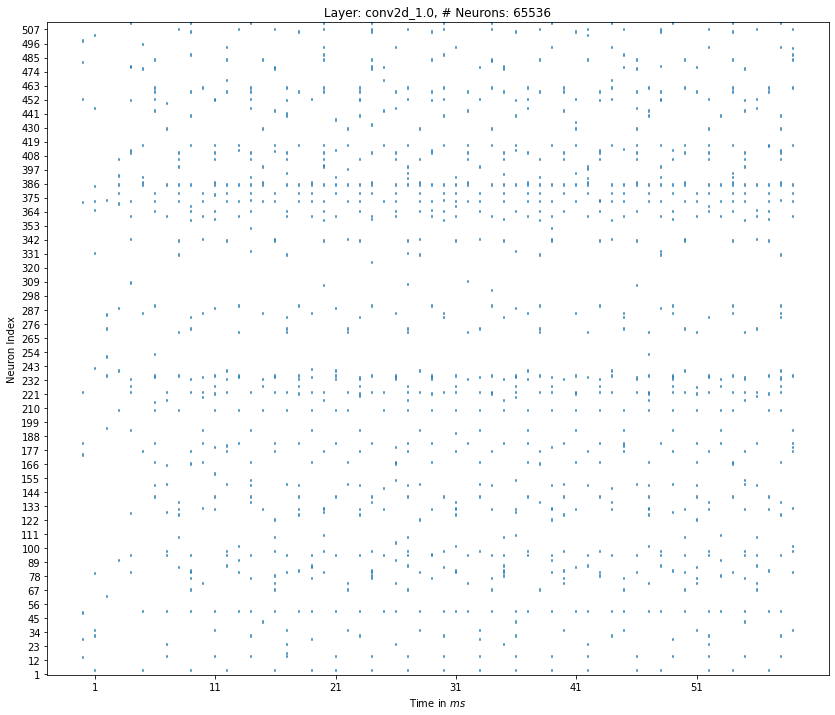

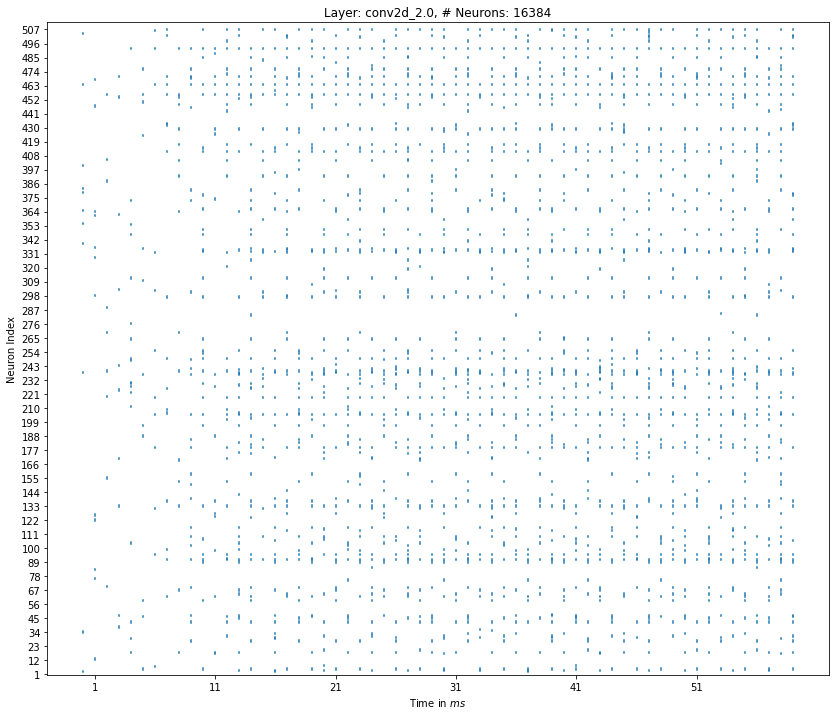

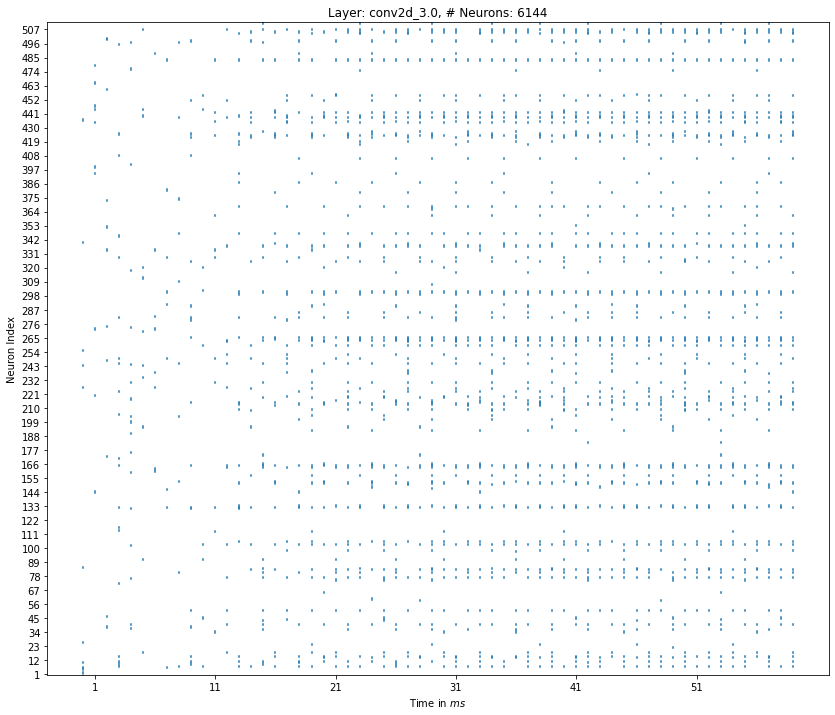

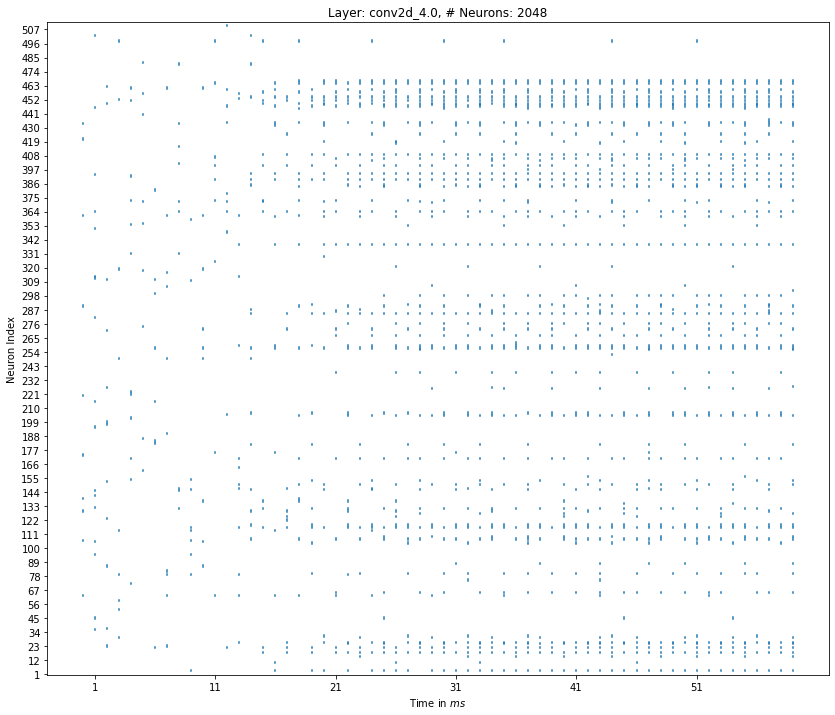

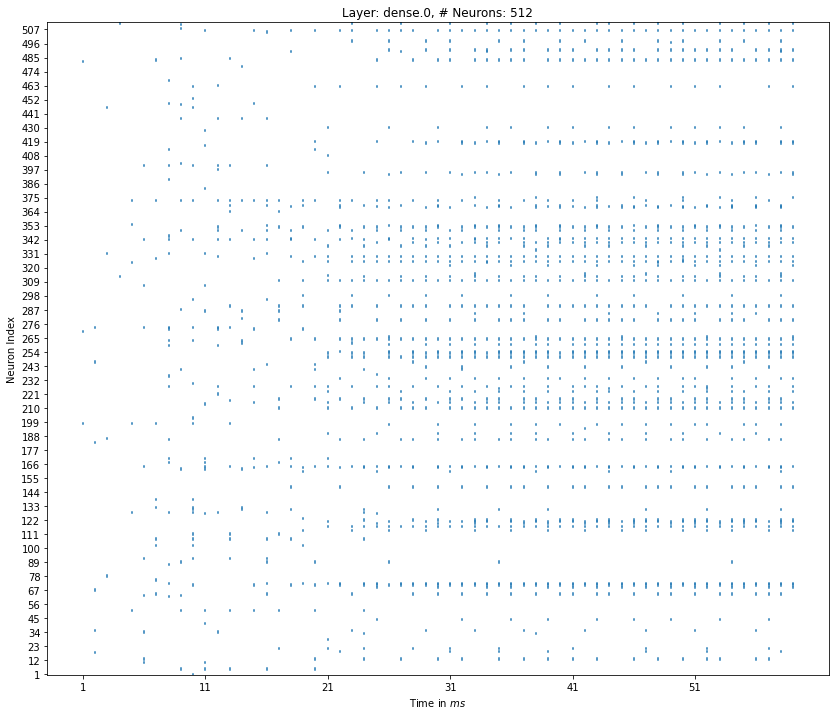

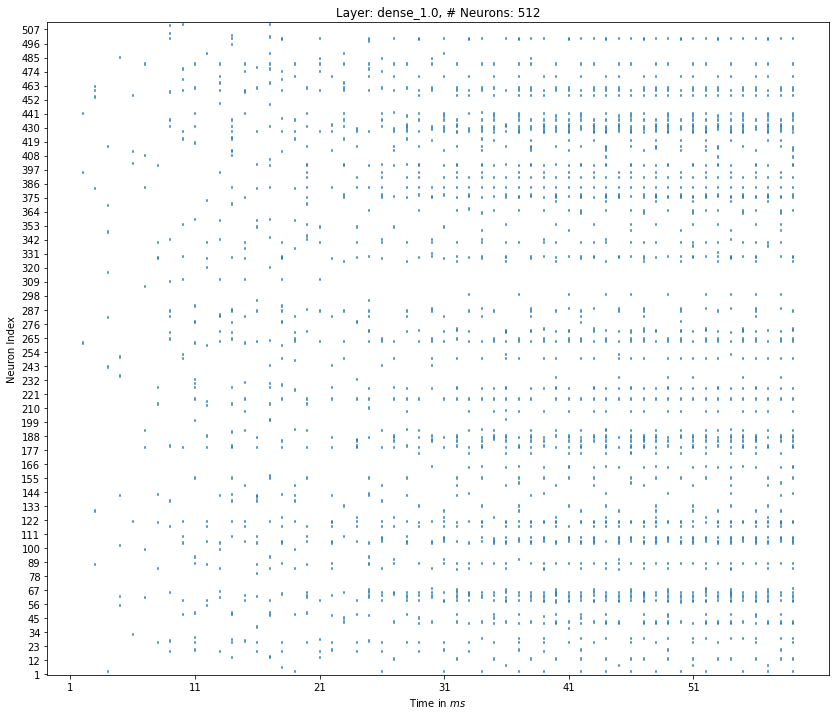

In [6]:
layer_names = ['conv2d.0', 'conv2d_1.0', 'conv2d_2.0', 'conv2d_3.0', 'conv2d_4.0', 'dense.0', 'dense_1.0']
for lyr_name in layer_names:
    plot_ndl_layer_spikes(lyr_name, ngo_cfg["sfr"], mdl_spks[0][lyr_name], num_random_neurons=512)